In [ ]:
from __future__ import print_function
import torch
from utils import Plotting,accuracy_plotting
from model1 import model_1,model_2,model_3,model_4,model_summary
#from model import model_1,model_summary
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.2, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #rightness=0.10, contrast=0.1,transforms.ColorJitter(b saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


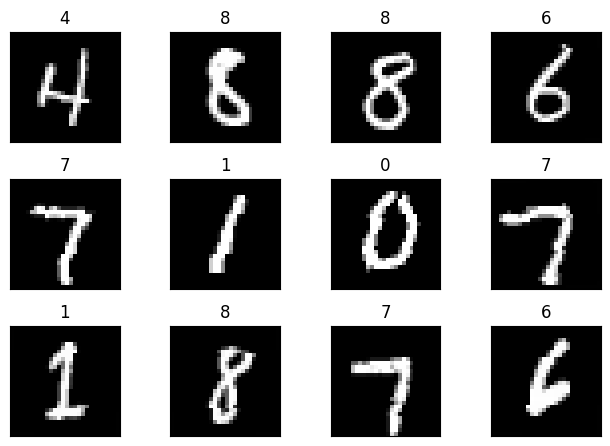

In [ ]:
Plotting(train_loader)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model2 = model_2().to(device)
model_summary(model2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4            [-1, 8, 28, 28]             584
              ReLU-5            [-1, 8, 28, 28]               0
       BatchNorm2d-6            [-1, 8, 28, 28]              16
            Conv2d-7            [-1, 8, 28, 28]             584
              ReLU-8            [-1, 8, 28, 28]               0
       BatchNorm2d-9            [-1, 8, 28, 28]              16
        MaxPool2d-10            [-1, 8, 14, 14]               0
          Dropout-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 12, 14, 14]             876
             ReLU-13           [-1, 12, 14, 14]               0
      BatchNorm2d-14           [-1, 12,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.10514848679304123 Batch_id=468 Accuracy=93.21: 100%|██████████| 469/469 [00:43<00:00, 10.79it/s]



Test set: Average loss: 0.0645, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.1035778746008873 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:42<00:00, 11.11it/s]



Test set: Average loss: 0.0809, Accuracy: 9764/10000 (97.64%)

EPOCH: 2


Loss=0.10260934382677078 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:42<00:00, 11.12it/s]



Test set: Average loss: 0.0399, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.03651299327611923 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:41<00:00, 11.25it/s]



Test set: Average loss: 0.0394, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.10206001251935959 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:40<00:00, 11.59it/s]



Test set: Average loss: 0.0364, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.011017858982086182 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:40<00:00, 11.68it/s]



Test set: Average loss: 0.0310, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.011429023928940296 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]



Test set: Average loss: 0.0234, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.06984848529100418 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0228, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.013203177601099014 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]



Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.004331712145358324 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]



Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.005005978513509035 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:39<00:00, 11.81it/s]



Test set: Average loss: 0.0219, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.06040817126631737 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:39<00:00, 11.83it/s]



Test set: Average loss: 0.0225, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.04647184535861015 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:39<00:00, 11.90it/s]



Test set: Average loss: 0.0220, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.09270735830068588 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]



Test set: Average loss: 0.0218, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.010133142583072186 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:39<00:00, 11.76it/s]



Test set: Average loss: 0.0218, Accuracy: 9938/10000 (99.38%)



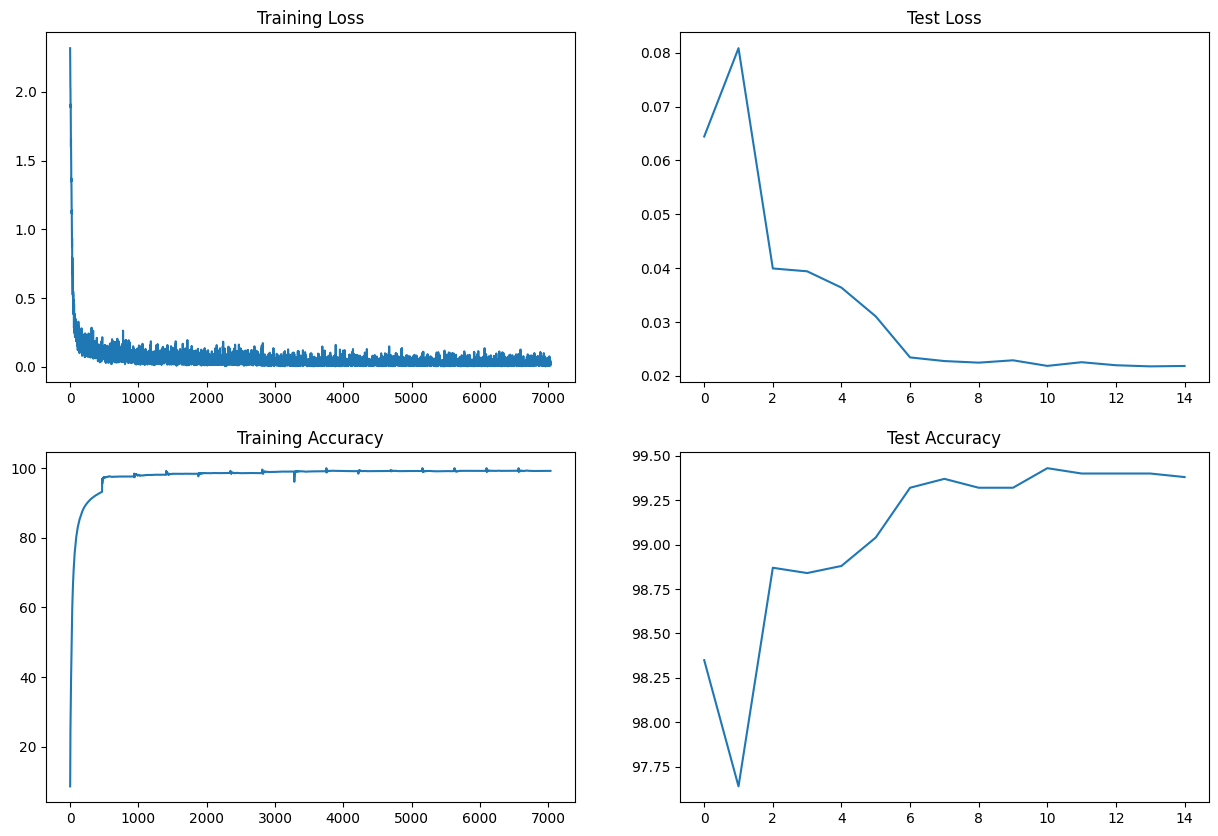

In [ ]:
accuracy_plotting(train_losses,train_acc,test_losses,test_acc)